Version 2025.01.03 - A. Lundervold

Lab 1: using the `elemd219-2025`conda environment 


[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2025/blob/main/Lab1-NetworkSci-PSN/notebooks/03-patient-similarity-networks-ibs-brain.ipynb)

# Patient similarity networks - ibs-brain

(https://github.com/arvidl/ibs-brain)

#### Data Loading and Path Handling

- Handles both local and Google Colab environments
- Automatically sets up correct paths and downloads data if needed
- Ensures code portability across different environments


#### Data Preprocessing

- Selects numerical columns for analysis
- Handles missing values using mean imputation
- Standardizes features to ensure equal scale importance
- Critical for meaningful similarity calculations


#### Network Creation

- Uses Euclidean distance to measure patient similarity
- Applies Gaussian kernel to convert distances to similarities
- Implements k-nearest neighbors approach to ensure balanced connectivity
- Uses similarity threshold to maintain meaningful connections
- Combines global threshold with local connectivity


#### Network Analysis

- Calculates basic network metrics (nodes, edges, density)
- Computes clustering coefficient to measure patient grouping
- Detects communities using modularity optimization
- Calculates centrality measures to identify key patients
- Provides insights into network structure


#### Network Visualization

- Uses spring layout for natural clustering visualization
- Node sizes reflect degree (number of connections)
- Colors indicate centrality (importance in network)
- Edge transparency shows similarity strength
- Includes colorbar for interpretation
- Optimized for readability and insight



#### Parameters that can be tuned:

- threshold: Controls minimum similarity for connection (0.3 default)
- k_nearest: Number of neighbors to connect (8 default)
- Node size scaling in visualization
- Edge transparency and width
- Layout parameters

#### The result is a network where:

- Similar patients are clustered together
- Node sizes show connectivity
- Colors show centrality/importance
- Communities are visually apparent
- Outliers are meaningfully connected
- Structure is interpretable

#### Import libraries

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
# StandardScaler: Standardizes features by removing the mean and scaling to unit variance
# Formula: z = (x - μ)/σ
# Used to ensure all features contribute equally to the analysis
# Normalizing your patient features so that variables with different scales 
# (e.g., age vs. test scores) can be compared fairly
from sklearn.preprocessing import StandardScaler
# pdist: Computes pairwise distances between observations in n-dimensional space
# squareform: Converts distance vector to square distance matrix and vice versa
# Example:
#   pdist([1,2], [3,4]) -> [distance]
#   squareform([distance]) -> [[0, distance],
#                             [distance, 0]]
# Computing how similar or different patients are from each other, which is essential for 
# creating the patient similarity network
from scipy.spatial.distance import pdist, squareform


In [2]:
# Step 1: Data Loading and Path Handling with mounting Google Drive
def setup_data_path_mounting():
    """Set up the correct data path whether running locally or in Colab"""
    try:
        # Try to import Google Colab specific module
        # If this succeeds, we're running in Colab
        from google.colab import drive
        
        # Mount Google Drive to access/save files persistently
        drive.mount('/content/drive')
        
        # Create a data directory in Colab's file system
        # -p flag creates parent directories if they don't exist
        !mkdir -p /content/data
        
        # Download the data file from GitHub using wget
        # -O flag specifies the output filename and path
        !wget -O /content/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv https://raw.githubusercontent.com/arvidl/ibs-brain/main/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv
        
        # Return Colab's data directory path
        return '/content/data'
        
    except:
        # If Google Colab import fails, we're running locally
        # Return local path: parent directory + 'data'
        return os.path.join(os.path.dirname(os.getcwd()), 'data')

In [3]:
# Setup data path without mounting Google Drive
def setup_data_path():
    """Set up the correct data path whether running locally or in Colab"""
    try:
        # Try to import Colab-specific module to detect environment
        from google.colab import drive
        
        # If we reach this point, we're in Colab, so:
        # 1. Create a data directory in Colab's temporary file system
        !mkdir -p data
        
        # 2. Download the data file from GitHub
        # -O flag: specify output filename
        !wget -O data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv https://raw.githubusercontent.com/arvidl/ibs-brain/main/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv
        
        # 3. Return simple 'data' path for Colab environment
        return 'data'
        
    except:
        # If Colab import fails, we're running locally
        # Return path that points to data directory one level up from current directory
        return os.path.join(os.path.dirname(os.getcwd()), 'data')

In [4]:
# Step 2: Data Preprocessing
def preprocess_data(df):
    """Preprocess the data for network analysis with NaN handling"""
    
    # Substep 1: Select only numerical columns
    # - Uses pandas select_dtypes to filter for numerical columns
    # - Essential because similarity calculations require numerical data
    # - Excludes categorical/text columns that can't be used for similarity
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Substep 2: Handle missing values (NaN)
    # - Uses mean imputation: replaces NaN with column mean
    # - Mean imputation is a simple but effective strategy for missing data
    # - Must handle NaN before scaling to avoid errors
    df_clean = df[numeric_cols].fillna(df[numeric_cols].mean())
    
    # Substep 3: Standardize features using StandardScaler
    # - Transforms each feature to have mean=0 and std=1
    # - Formula: z = (x - μ)/σ
    # - Ensures all features contribute equally regardless of original scale
    # - Critical when features have different units or ranges
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean)
    
    # Returns:
    # - scaled_data: preprocessed and standardized numerical data
    # - numeric_cols: list of numerical column names used
    return scaled_data, numeric_cols

In [5]:
# Step 3: Network Creation
def create_similarity_network(scaled_data, threshold=0.5, k_nearest=5):
    """
    Create a similarity network based on patient features and k-nearest neighbors
    where:   Similar patients are connected by edges 
            Edge weights represent similarity strength
            Each patient connects to their k most similar neighbors
    Parameters:
        scaled_data: Preprocessed patient data (output from preprocess_data)
        threshold: Minimum similarity required for connection (default=0.5)
        k_nearest: Number of neighbors to connect to each node (default=5)
    """
    
    # Substep 1: Calculate pairwise distances between all patients
    # - Uses Euclidean distance: sqrt(sum((x1-x2)^2))
    # - pdist creates a condensed distance matrix
    distances = pdist(scaled_data, metric='euclidean')
    
    # Substep 2: Convert distances to similarities using Gaussian kernel
    # - Formula: exp(-d^2 / (2*sigma^2))
    # - sigma is mean distance (adds small epsilon to avoid division by zero)
    # - Transforms distances to similarities in range [0,1]
    sigma = np.mean(distances) + 1e-8
    similarities = np.exp(-distances ** 2 / (2 * sigma ** 2))
    # Convert to square matrix format for easier indexing
    sim_matrix = squareform(similarities)
    
    # Substep 3: Create empty network
    # - Initialize undirected graph
    # - Add nodes for each patient
    G = nx.Graph()
    n_patients = len(scaled_data)
    G.add_nodes_from(range(n_patients))
    
    # Substep 4: Connect nodes based on similarity
    # - For each patient, find k most similar other patients
    # - Only add edge if similarity > threshold
    # - Combines global threshold with local connectivity
    for i in range(n_patients):
        # Get indices of k most similar patients (excluding self)
        neighbors = np.argsort(sim_matrix[i])[-k_nearest-1:-1]
        for j in neighbors:
            if sim_matrix[i,j] > threshold:
                G.add_edge(i, j, weight=sim_matrix[i,j])
    
    # Returns:
    # - G: NetworkX graph with patients as nodes and similarities as edge weights
    # - sim_matrix: Full similarity matrix for potential further analysis
    return G, sim_matrix

In [6]:
# Step 4: Network Analysis
def analyze_network(G):
    """
    Calculate and display comprehensive network metrics
    The input G is a NetworkX graph object that was created by the create_similarity_network() function.
    This function performs three main types of network analysis:
    (1) Basic Network Metrics:
        - Counts nodes (patients) and edges (connections)
        - Calculates average connections per patient
        - Measures network density and clustering
    (2) Community Detection:
        - Identifies groups of closely connected patients
        - Uses modularity optimization to find natural groupings
    (3) Centrality Analysis:
        - Degree centrality shows which patients have most connections
        - Betweenness centrality identifies bridge patients between groups
    The results help understand the network's structure and identify important patients or patient groups.
    """
    
    # Substep 1: Calculate and display basic network statistics
    # - Number of nodes: total patients in network
    # - Number of edges: total connections between patients
    # - Average degree: average number of connections per patient
    # - Network density: proportion of possible connections that exist
    # - Clustering coefficient: measure of patient grouping tendency
    print("\nNetwork Analysis:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G):.3f}")
    print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
    
    # Substep 2: Detect communities in the network
    # - Uses greedy modularity optimization algorithm
    # - Groups patients into distinct communities
    # - Communities are groups of densely connected patients
    communities = list(nx.community.greedy_modularity_communities(G))
    print(f"\nNumber of communities detected: {len(communities)}")
    
    # Substep 3: Calculate centrality measures
    # - Degree centrality: how many connections each patient has
    # - Betweenness centrality: how important each patient is for connecting others
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    
    # Returns three key network metrics:
    # - degree_cent: measure of connection counts
    # - betweenness_cent: measure of node importance
    # - communities: detected patient groups
    return degree_cent, betweenness_cent, communities

In [7]:
# Step 5: Network Visualization
def visualize_network(G, node_colors=None, pos=None):
    """
    Enhanced network visualization
    This visualization function creates a network plot where:
    (1) Node size indicates number of connections
    (2) Node color indicates centrality/importance
    (3) Edge thickness shows similarity strength
    (4) Layout groups similar patients together
    (5) Colorbar helps interpret node colors
    The result is an intuitive visualization of patient relationships and network structure.
    """
    
    # Substep 1: Create figure and axis objects
    # - Sets up a large figure size for better visibility
    # - Creates explicit axis for proper colorbar placement
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Substep 2: Calculate node positions if not provided
    # - Uses spring layout algorithm for natural clustering
    # - k parameter controls spacing between nodes
    # - More iterations = more stable layout
    if pos is None:
        pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
    
    # Substep 3: Calculate node sizes based on degree
    # - Larger nodes = more connections
    # - Add 1 to ensure even disconnected nodes are visible
    degree_dict = dict(G.degree())
    node_sizes = [((v + 1) * 100) for v in degree_dict.values()]
    
    # Substep 4: Set up node colors
    # - Uses provided colors or defaults to degree centrality
    # - Higher values = darker color
    node_colors = list(node_colors.values()) if node_colors else list(nx.degree_centrality(G).values())
    
    # Substep 5: Draw nodes
    # - Size reflects connectivity
    # - Color reflects centrality
    # - Uses viridis colormap
    # - Partial transparency for better visibility
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes,
                          node_color=node_colors,
                          cmap=plt.cm.viridis,
                          alpha=0.7,
                          ax=ax)
    
    # Substep 6: Draw edges
    # - Width reflects similarity strength
    # - Low opacity to reduce visual clutter
    edge_weights = [G[u][v].get('weight', 0.1) for u,v in G.edges()]
    nx.draw_networkx_edges(G, pos, 
                          alpha=0.2,
                          width=[w*2 for w in edge_weights],
                          ax=ax)
    
    # Substep 7: Add title and remove axis
    plt.title('Patient Similarity Network\n(Node size: degree, Color: centrality)')
    ax.set_axis_off()
    
    # Substep 8: Add colorbar
    # - Shows scale for centrality scores
    # - Properly aligned with main plot
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Centrality Score')
    
    # Substep 9: Adjust layout and display
    plt.tight_layout()
    plt.show()

In [8]:
def create_and_analyze_network(threshold=0.3, k_nearest=8):
    """
    Create and analyze patient similarity network
    
    Parameters:
    -----------
    threshold : float, default=0.3
        Minimum similarity required for connection
        Lower values create more connections
    k_nearest : int, default=8
        Number of nearest neighbors to connect
        Higher values create denser networks
    
    Returns:
    --------
    G : NetworkX graph
        The patient similarity network
    metrics : tuple
        (degree_centrality, betweenness_centrality, communities)
    """
    
    # Step 1: Setup and load data
    # - Sets up correct path for local/Colab environment
    # - Loads patient data from CSV file
    DATA_PATH = setup_data_path()
    DATA_FILE = 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv'
    df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILE))
    print(f"Loaded data shape: {df.shape}")

    # Step 2: Preprocess data
    # - Selects numerical features
    # - Handles missing values
    # - Standardizes the data
    scaled_data, feature_cols = preprocess_data(df)
    print(f"\nFeatures used: {len(feature_cols)}")

    # Step 3: Create network
    # - Uses provided threshold and k_nearest parameters
    # - Creates patient similarity network based on feature similarity
    G, similarity_matrix = create_similarity_network(scaled_data, 
                                                   threshold=threshold, 
                                                   k_nearest=k_nearest)

    # Step 4: Analyze network
    # - Calculates network metrics
    # - Detects communities
    # - Computes centrality measures
    metrics = analyze_network(G)
    
    # Step 5: Visualize network
    # - Creates network visualization
    # - Node size shows connectivity
    # - Node color shows centrality
    visualize_network(G, metrics[0])  # Using degree_centrality for colors

    return G, metrics, scaled_data, feature_cols

Loaded data shape: (78, 48)

Features used: 45

Network Analysis:
Number of nodes: 78
Number of edges: 496
Average degree: 12.72
Network density: 0.165
Average clustering coefficient: 0.422

Number of communities detected: 3


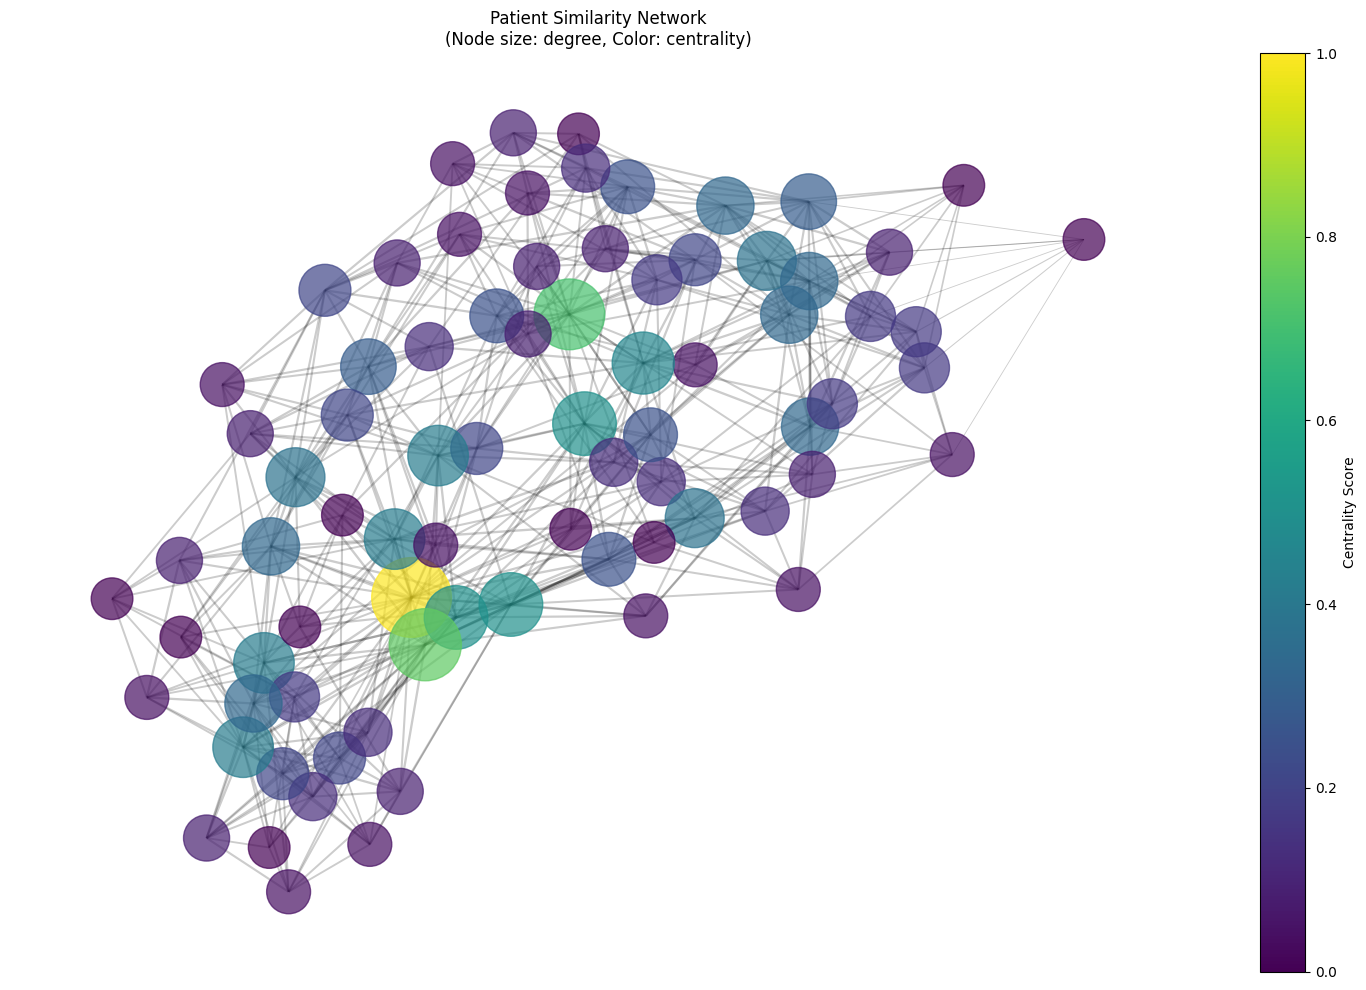

In [9]:
# Example usage:
if __name__ == "__main__":
    # Use default parameters
    G, (degree_cent, between_cent, communities), scaled_data, feature_cols = create_and_analyze_network()
    
    # Or specify custom parameters
    # G, metrics = create_and_analyze_network(threshold=0.4, k_nearest=10)

This Patient Similarity Network visualization reveals several interesting patterns:

1. **Node Characteristics:**
   - Each node represents a patient
   - Node size indicates degree (number of connections)
   - Colors represent centrality (from purple=low to yellow=high)

2. **Network Structure:**
   - There are several hub patients (larger nodes) that are well-connected
   - A few nodes show high centrality (green/yellow) indicating they are important bridge points
   - The network shows clear clustering, suggesting subgroups of similar patients
   - Some peripheral patients (smaller, purple nodes) are less connected

3. **Clinical Implications:**
   - The clusters might represent distinct patient subgroups with similar characteristics
   - The bridge nodes (high centrality) could represent patients with characteristics that span multiple groups
   - The network is well-connected overall, suggesting gradual transitions between patient types
   - Peripheral nodes might represent patients with unique or unusual combinations of characteristics

4. **Network Properties:**
   - The network appears to have good balance between connectivity and structure
   - The chosen threshold and k-nearest neighbor parameters have created meaningful groupings
   - The visualization effectively shows both local connections and global structure

This visualization could help clinicians identify patient subgroups and understand the relationships between different patient characteristics in the dataset.



Similarity statistics:
Min similarity: 0.002
Max similarity: 0.841
Mean similarity: 0.414
Median similarity: 0.426


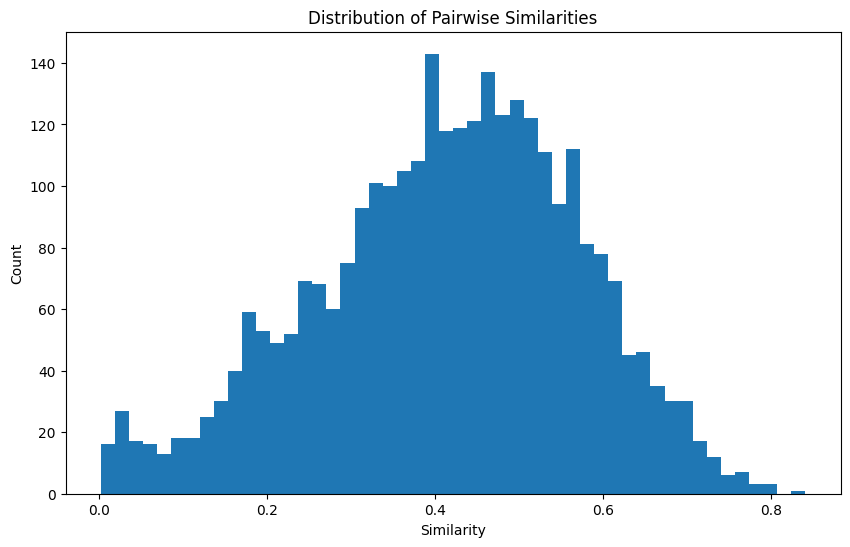

In [10]:
# Analyze similarity distribution
# Step 1: Calculate pairwise distances and convert to similarities
distances = pdist(scaled_data, metric='euclidean')
# Convert distances to similarities using Gaussian kernel
# Formula: exp(-d^2 / mean(d^2))
# This transforms distances into similarity scores between 0 and 1
# - 1 means identical patients
# - 0 means maximally different patients
similarities = np.exp(-distances ** 2 / np.mean(distances ** 2))

# Step 2: Print basic statistics about similarities
print("\nSimilarity statistics:")
print(f"Min similarity: {similarities.min():.3f}")  # Most different pair of patients
print(f"Max similarity: {similarities.max():.3f}")  # Most similar pair of patients
print(f"Mean similarity: {similarities.mean():.3f}")  # Average similarity
print(f"Median similarity: {np.median(similarities):.3f}")  # Middle similarity value

# Step 3: Visualize the distribution of similarities
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=50)  # Create histogram with 50 bins
plt.title('Distribution of Pairwise Similarities')
plt.xlabel('Similarity')  # 0=different, 1=identical
plt.ylabel('Count')  # Number of patient pairs with this similarity
plt.show()

In [13]:
# Read the data from the CSV file at the ibs-brain repository 

fn = 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv'
df = pd.read_csv(f'https://raw.githubusercontent.com/arvidl/ibs-brain/main/data/{fn}')
df


,Subject,Group,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,...,Fullscale_RBANS,Memory_Index,Visuospatial_Index,Verbalskills_Index,Attention_Index,Recall_Index,IBS_SSS,Age,Gender,Education
0,BGA_046,IBS,1.743419e+06,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,0.003099,...,100,80,102,93,97,86,195.0,38,M,12.0
1,BGA_047,IBS,1.360311e+06,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,0.002999,...,116,109,107,97,115,126,325.0,19,F,13.0
2,BGA_048,IBS,1.350452e+06,0.011099,0.037770,0.005755,0.002750,0.004094,0.001498,0.003533,...,95,83,84,113,103,100,326.0,34,F,13.0
3,BGA_050,IBS,1.595000e+06,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,...,87,86,97,90,98,86,357.0,44,F,18.0
4,BGA_051,IBS,1.645577e+06,0.010128,0.034373,0.005717,0.002209,0.003332,0.001317,0.002864,...,100,105,90,97,108,100,293.0,38,M,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,BGA_166,HC,1.399586e+06,0.011516,0.034967,0.005952,0.002364,0.003272,0.001358,0.002845,...,93,89,90,118,108,82,56.0,19,F,NaN
74,BGA_167,HC,1.394849e+06,0.011416,0.031906,0.005171,0.002180,0.003092,0.001154,0.002759,...,97,83,85,116,113,23,25.0,52,F,NaN
75,BGA_168,HC,1.259360e+06,0.012970,0.041197,0.006277,0.003057,0.004054,0.001500,0.003182,...,100,100,103,107,86,104,21.0,50,F,NaN
76,BGA_171,HC,1.609011e+06,0.010545,0.040919,0.005930,0.002501,0.003863,0.001624,0.002967,...,96,89,102,85,101,110,32.0,21,M,NaN


_With the information in data frame df, modify the steps Step 1, ..., Step 5 such that the similarity is based only on the morphometric variables and the cognitive variables, excluding Subject, Group, IBS_SSS, Age, Gender and Education._

_For the visualization in Step 5, mark each node with subject number and gender  (e.g. BGA_046 -> 46/M , ..., BGA_172 -> 172/F) and let nodes having Group == IBS be marked with a square-shaped node and Group == HC be circle-shaped._

Features used: 42

Network Analysis:
Number of nodes: 78
Number of edges: 495
Average degree: 12.69
Network density: 0.165
Average clustering coefficient: 0.420

Number of communities detected: 3


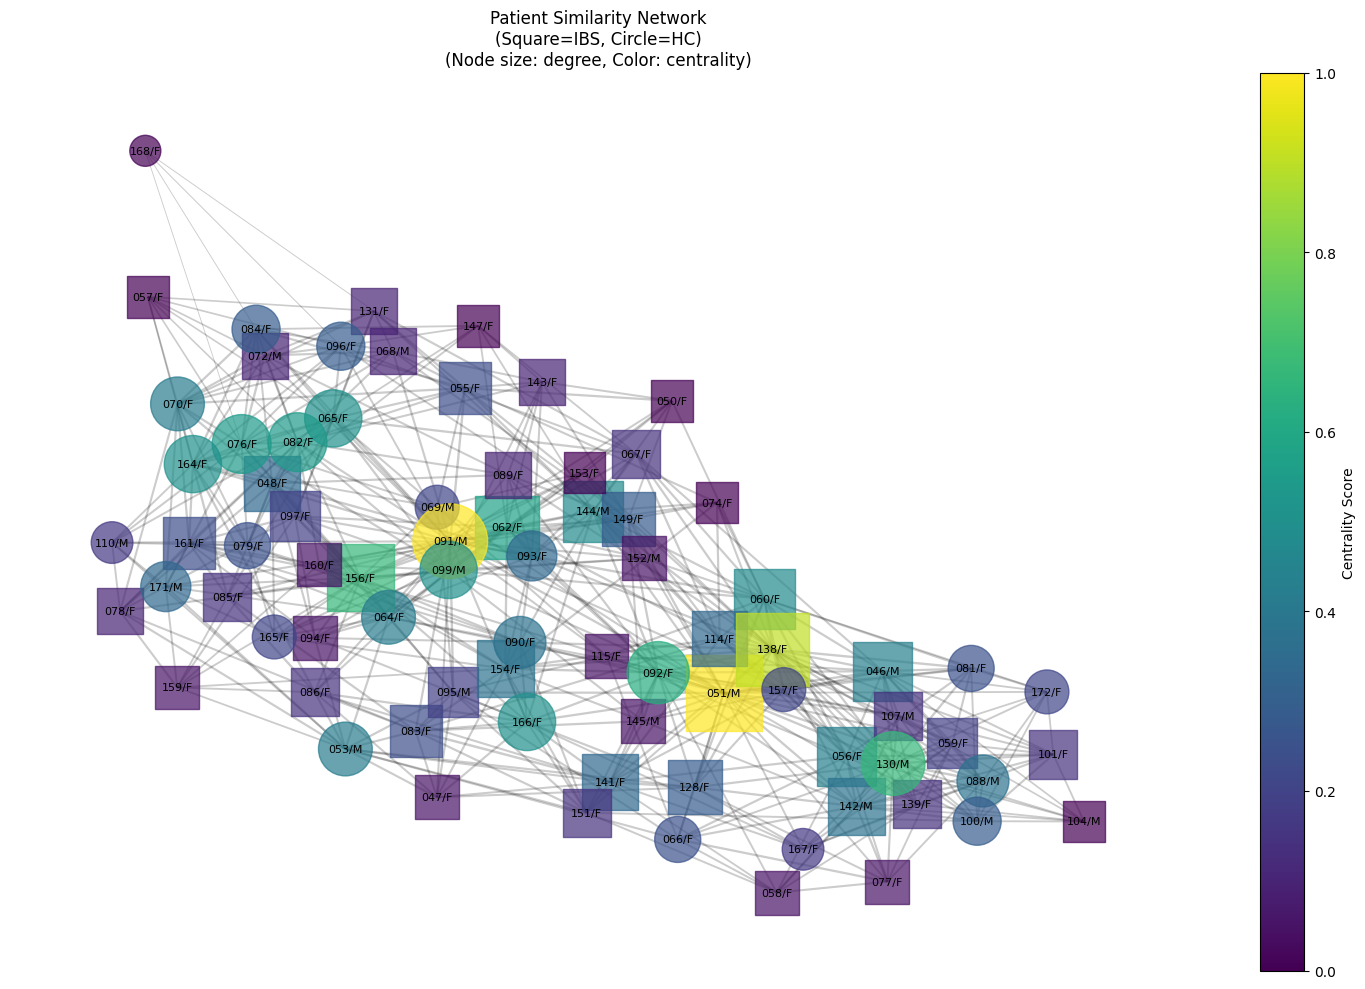

In [16]:
def create_and_analyze_network(threshold=0.3, k_nearest=8):
    """
    Create and analyze patient similarity network based on morphometric and cognitive variables only
    """
    
    # Step 1: Setup and load data
    DATA_PATH = setup_data_path()
    DATA_FILE = 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv'
    df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILE))
    
    # Store subject info for later use in visualization
    subject_info = df[['Subject', 'Group', 'Gender']].copy()
    
    # Step 2: Preprocess data - select only morphometric and cognitive variables
    # Exclude demographic and clinical variables
    exclude_cols = ['Subject', 'Group', 'IBS_SSS', 'Age', 'Gender', 'Education']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Preprocess selected features
    scaled_data = StandardScaler().fit_transform(df[feature_cols])
    print(f"Features used: {len(feature_cols)}")

    # Step 3: Create network
    G, similarity_matrix = create_similarity_network(scaled_data, 
                                                   threshold=threshold, 
                                                   k_nearest=k_nearest)

    # Step 4: Analyze network
    metrics = analyze_network(G)
    
    # Step 5: Enhanced visualization with subject labels and group-based node shapes
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Calculate layout
    pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
    
    # Prepare node colors and sizes
    node_colors = list(metrics[0].values())
    degree_dict = dict(G.degree())
    node_sizes = [((v + 1) * 100) for v in degree_dict.values()]
    
    # Draw nodes based on group (IBS=square, HC=circle)
    ibs_nodes = [i for i, row in subject_info.iterrows() if row['Group'] == 'IBS']
    hc_nodes = [i for i, row in subject_info.iterrows() if row['Group'] == 'HC']
    
    # Draw IBS nodes (squares)
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=ibs_nodes,
                          node_color=[node_colors[i] for i in ibs_nodes],
                          node_size=[node_sizes[i] for i in ibs_nodes],
                          node_shape='s',  # square
                          cmap=plt.cm.viridis,
                          alpha=0.7,
                          ax=ax)
    
    # Draw HC nodes (circles)
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=hc_nodes,
                          node_color=[node_colors[i] for i in hc_nodes],
                          node_size=[node_sizes[i] for i in hc_nodes],
                          node_shape='o',  # circle
                          cmap=plt.cm.viridis,
                          alpha=0.7,
                          ax=ax)
    
    # Draw edges
    edge_weights = [G[u][v].get('weight', 0.1) for u,v in G.edges()]
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=[w*2 for w in edge_weights])
    
    # Add node labels (subject number and gender)
    labels = {i: f"{row['Subject'].split('_')[1]}/{row['Gender']}" 
             for i, row in subject_info.iterrows()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title('Patient Similarity Network\n(Square=IBS, Circle=HC)\n(Node size: degree, Color: centrality)')
    ax.set_axis_off()
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Centrality Score')
    
    plt.tight_layout()
    plt.show()
    
    return G, metrics, scaled_data, feature_cols

# Example usage:
if __name__ == "__main__":
    G, metrics, scaled_data, feature_cols = create_and_analyze_network()

_Display the graph for each community, separately._

Features used: 42

Network Analysis:
Number of nodes: 78
Number of edges: 495
Average degree: 12.69
Network density: 0.165
Average clustering coefficient: 0.420

Number of communities detected: 3


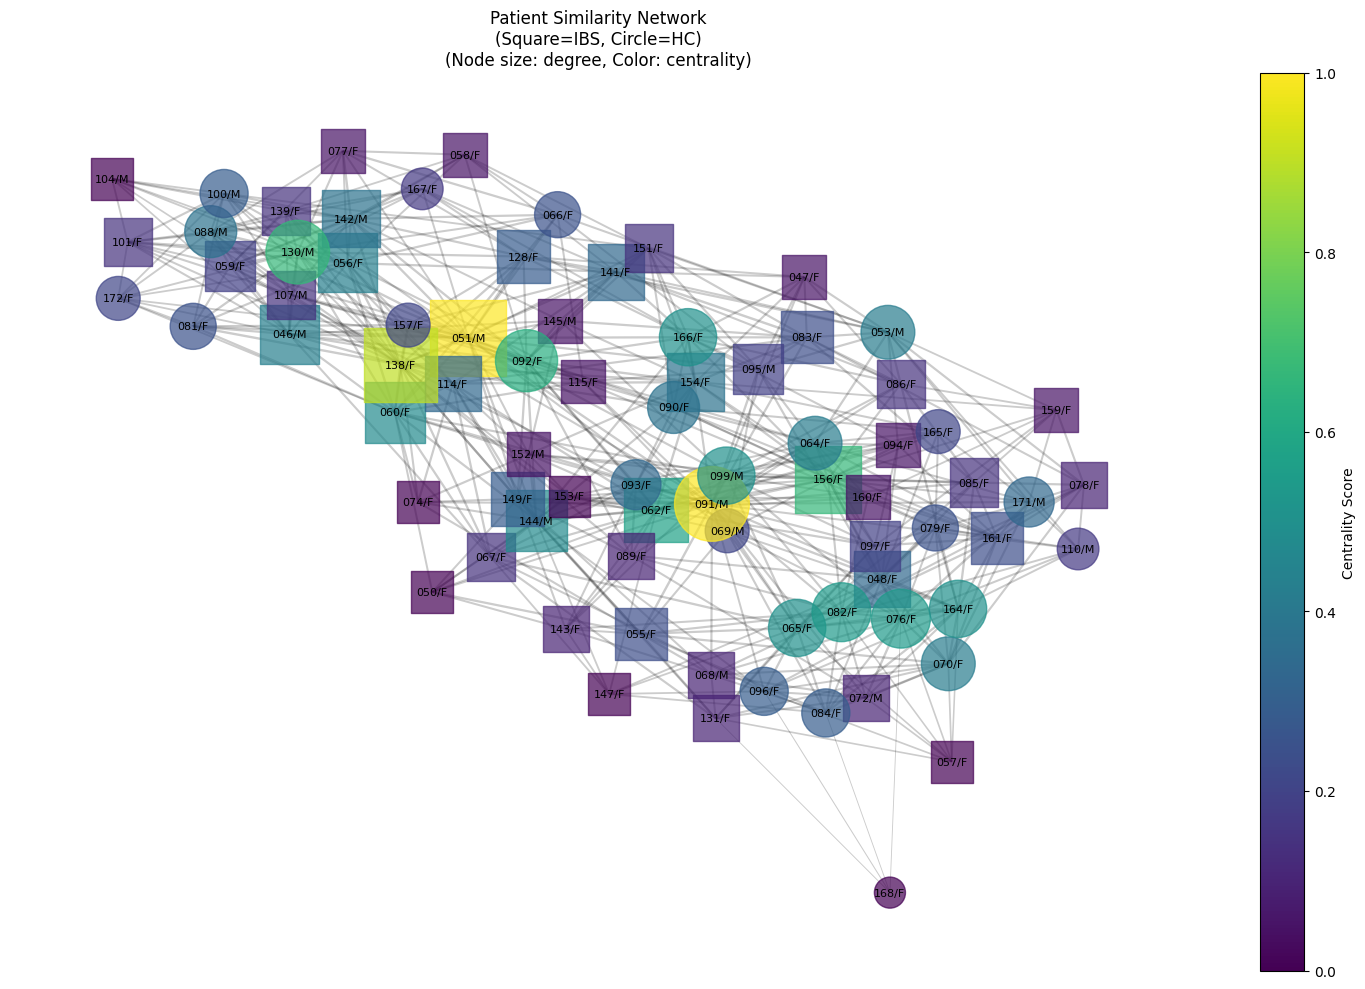

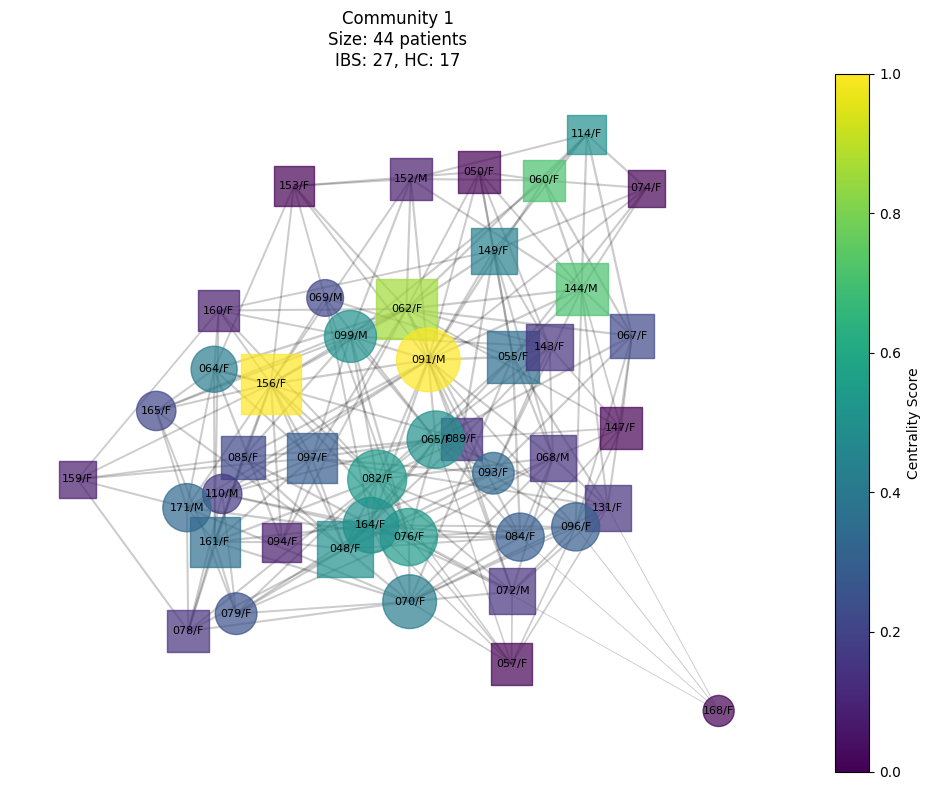


Community 1 Statistics:
Total patients: 44
IBS patients: 27 (61.4%)
HC patients: 17 (38.6%)
--------------------------------------------------


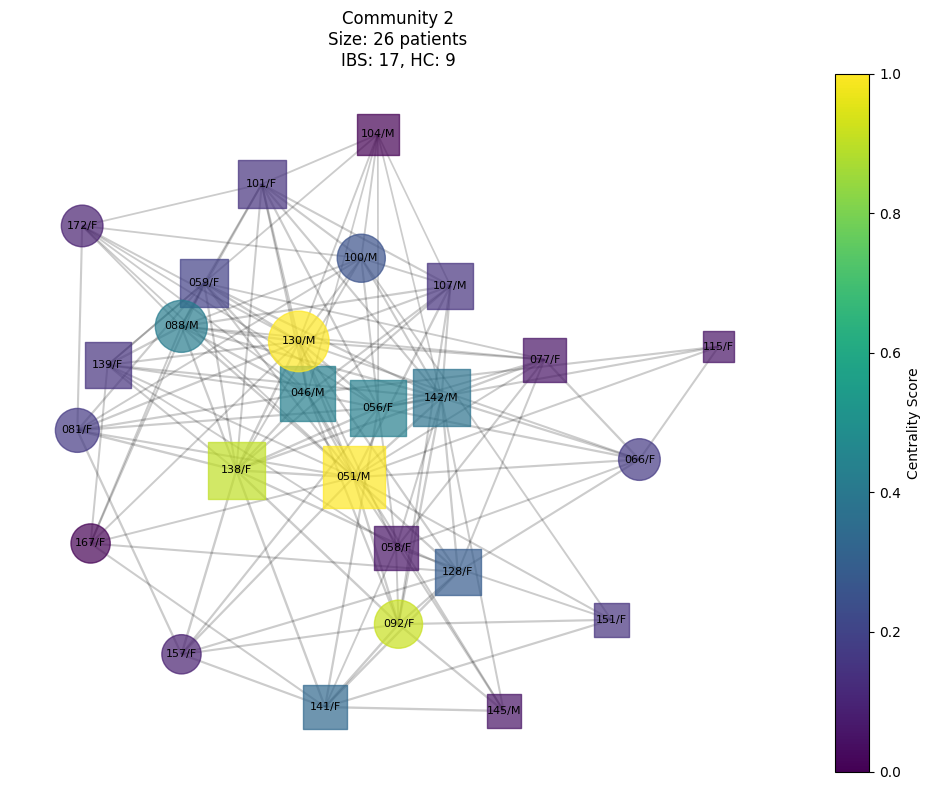


Community 2 Statistics:
Total patients: 26
IBS patients: 17 (65.4%)
HC patients: 9 (34.6%)
--------------------------------------------------


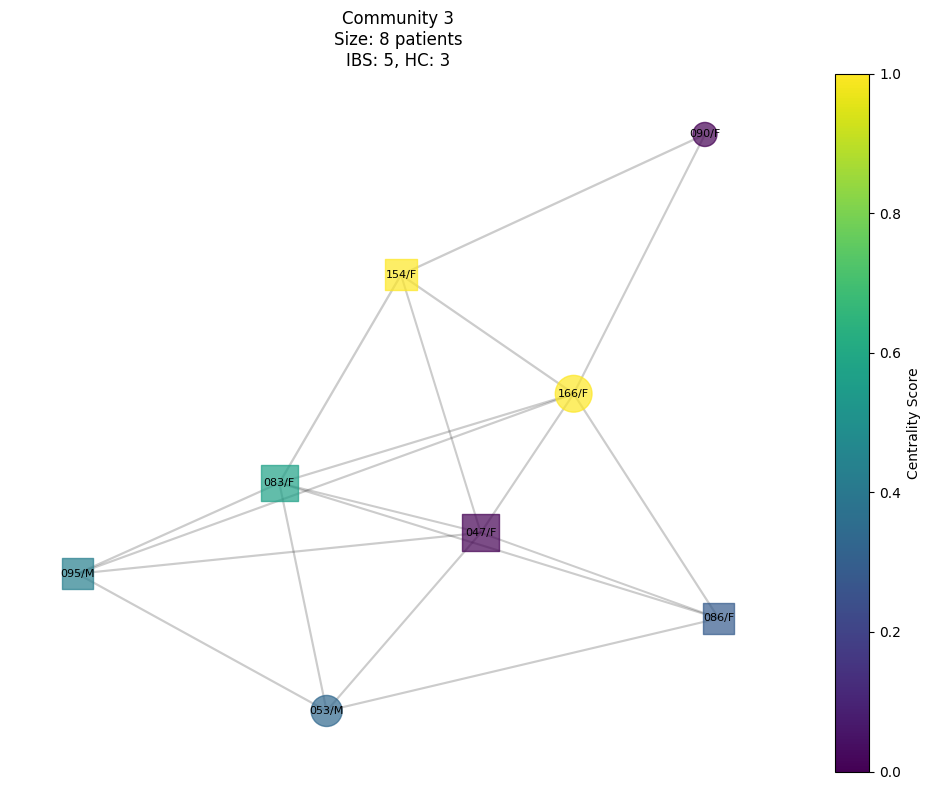


Community 3 Statistics:
Total patients: 8
IBS patients: 5 (62.5%)
HC patients: 3 (37.5%)
--------------------------------------------------


In [17]:
def visualize_communities(G, communities, subject_info, metrics):
    """
    Display separate graphs for each community in the network
    
    Parameters:
    -----------
    G : NetworkX graph
        The patient similarity network
    communities : list
        List of sets containing node indices for each community
    subject_info : DataFrame
        Contains Subject, Group, and Gender information
    metrics : tuple
        (degree_centrality, betweenness_centrality, communities)
    """
    
    # For each community
    for idx, community in enumerate(communities):
        # Create subgraph for this community
        subG = G.subgraph(community)
        
        # Create new figure for this community
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Calculate layout for this subgraph
        pos = nx.spring_layout(subG, k=1/np.sqrt(len(community)), iterations=50)
        
        # Prepare node colors and sizes for this community
        node_colors = [metrics[0][node] for node in subG.nodes()]
        node_sizes = [((subG.degree(node) + 1) * 100) for node in subG.nodes()]
        
        # Separate IBS and HC nodes
        ibs_nodes = [i for i in subG.nodes() if subject_info.iloc[i]['Group'] == 'IBS']
        hc_nodes = [i for i in subG.nodes() if subject_info.iloc[i]['Group'] == 'HC']
        
        # Draw IBS nodes (squares)
        if ibs_nodes:
            nx.draw_networkx_nodes(subG, pos,
                                 nodelist=ibs_nodes,
                                 node_color=[metrics[0][i] for i in ibs_nodes],
                                 node_size=[node_sizes[list(subG.nodes()).index(i)] for i in ibs_nodes],
                                 node_shape='s',
                                 cmap=plt.cm.viridis,
                                 alpha=0.7,
                                 ax=ax)
        
        # Draw HC nodes (circles)
        if hc_nodes:
            nx.draw_networkx_nodes(subG, pos,
                                 nodelist=hc_nodes,
                                 node_color=[metrics[0][i] for i in hc_nodes],
                                 node_size=[node_sizes[list(subG.nodes()).index(i)] for i in hc_nodes],
                                 node_shape='o',
                                 cmap=plt.cm.viridis,
                                 alpha=0.7,
                                 ax=ax)
        
        # Draw edges
        edge_weights = [subG[u][v].get('weight', 0.1) for u,v in subG.edges()]
        nx.draw_networkx_edges(subG, pos, alpha=0.2, width=[w*2 for w in edge_weights])
        
        # Add node labels
        labels = {i: f"{subject_info.iloc[i]['Subject'].split('_')[1]}/{subject_info.iloc[i]['Gender']}"
                 for i in subG.nodes()}
        nx.draw_networkx_labels(subG, pos, labels, font_size=8)
        
        # Add title and stats for this community
        plt.title(f'Community {idx+1}\n'
                 f'Size: {len(community)} patients\n'
                 f'IBS: {len(ibs_nodes)}, HC: {len(hc_nodes)}')
        ax.set_axis_off()
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Centrality Score')
        
        plt.tight_layout()
        plt.show()
        
        # Print community statistics
        print(f"\nCommunity {idx+1} Statistics:")
        print(f"Total patients: {len(community)}")
        print(f"IBS patients: {len(ibs_nodes)} ({len(ibs_nodes)/len(community)*100:.1f}%)")
        print(f"HC patients: {len(hc_nodes)} ({len(hc_nodes)/len(community)*100:.1f}%)")
        print("-" * 50)

# Modify the main function to include community visualization
if __name__ == "__main__":
    G, (degree_cent, between_cent, communities), scaled_data, feature_cols = create_and_analyze_network()
    
    # Get subject info from original data
    DATA_PATH = setup_data_path()
    DATA_FILE = 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv'
    df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILE))
    subject_info = df[['Subject', 'Group', 'Gender']]
    
    # Visualize each community
    visualize_communities(G, communities, subject_info, (degree_cent, between_cent, communities))